# 03a Validate CATE estimators GI

In this notebook, we will try to validate CATE estimators with respect to the GI outcome.

### Contents:
1. Set up
2. Calibration and R2  
2.1. Calibration plots for a fixed data split  
2.2. CR2 generalization scatter plots  
2.3. Aggregate R2 statistics. 
3. Monotonicity  
3.1. Monotinicity with respect to 5 bins  
3.2. Comparing quantile-based top subgroup with its complement  
4. Stability of CATE estimators  
4.1. Stability of quantile-based top subgroup  
4.2. Overlaps of quantile-based subgroups  
4.3. Aggregate correlation statistics  
4.4. Pairwise correlation for a single estimator when trained on different splits

## 1. Set up

In [1]:
# Standard imports
import numpy as np
import pandas as pd
from scipy import stats
import os
import copy
import random
import joblib

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
import pylab
from cycler import cycler

# Import sklearn methods
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.model_selection import StratifiedKFold

# Import own methods
from methods.data_processing import prepare_df, separate_vars
from methods.cate_estimator_validation import \
            (make_estimator_library, fit_estimator_libraries, 
             get_calibration_plot_data, get_cr2_plot_data, 
             get_calibration_score, get_cr2_score, get_r_values, 
             get_overlap_values, get_monotonicity_results, 
             combine_estimator_versions, get_top_subgroup_stability)

Failed to import duecredit due to No module named 'duecredit'


In [2]:
n_splits = 4
q_values = np.array([0.1, 0.2, 0.3, 0.4, 0.5])

base_learners = {"lasso" : Lasso(),
                 "logistic" : LogisticRegression(solver = "liblinear", 
                                                 max_iter = 500),
                 "rf" : RandomForestRegressor(),
                 "xgb" : XGBRegressor(objective = "reg:squarederror")}

outcome = 'fausebal'
dir_neg = False
n_bins = 10

In [3]:
# Global plot style settings
plt.style.use("fivethirtyeight")
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['grid.linewidth'] = 2.5
mpl.rcParams['legend.fontsize'] = 20
pylab.rcParams['xtick.major.pad'] = 5
pylab.rcParams['ytick.major.pad'] = 5
mpl.rcParams["figure.figsize"] = [8, 6]
mpl.rcParams['savefig.transparent'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.edgecolor'] = 'black'
# plt.rcParams['patch.edgecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
# plt.rcParams['grid.color'] = 'black'

# Force grayscale styling for every plot
grayscale_palette = [
    '#1a1a1a',
    '#2f2f2f',
    '#454545',
    '#5c5c5c',
    '#727272',
    '#898989',
    '#a0a0a0',
    '#b6b6b6',
    '#cdcdcd',
    '#e3e3e3'
]
mpl.rcParams['axes.prop_cycle'] = cycler(color=grayscale_palette)
sns.set_palette(grayscale_palette)
annotation_box_color = '#4d4d4d'
colors = grayscale_palette

label_size = 25
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size

# Save settings
SAVE_PATH  = f"figs/{outcome}/"
savfig = True


In [4]:
# Prefer imputed dataset from 02 (no recomputation)
from pathlib import Path
import pickle

IMPUTATION_META = Path(f"output/params/{outcome}/analysis_imputation_meta.pkl")

if IMPUTATION_META.exists():
    with open(IMPUTATION_META, 'rb') as f:
        _meta = pickle.load(f)
    # Determine treatment and outcome
    treatment = _meta.get("treatment_var", "message_fa")
    outcomes = _meta.get("outcomes", [])
    # Determine features
    features = _meta.get("features", None)
    print("✓ Loaded metadata from 02")
else:
    print("Dataset from 02 not found; using locally computed features/imputation.")


✓ Loaded metadata from 02


### 1.1. Fit estimators in the library

In [5]:
import warnings
warnings.filterwarnings("ignore")
# Load tuned params (now consolidated into a single file holding all splits)
MODEL_CSV = Path("output/analysis/")
tuned_params = joblib.load(f"output/params/{outcome}/{outcome}_tuned_params.pkl")

if not os.path.exists(f"output/analysis/{outcome}/{outcome}_fitted_libraries.pkl"):
    fitted_libraries = fit_estimator_libraries(MODEL_CSV, features, outcome, 
                                            base_learners, tuned_params, n_splits, 
                                            perturbed = True, num_cv_splits = 2)
    # Dump the fitted libraries
    joblib.dump(fitted_libraries, f"output/analysis/{outcome}/{outcome}_fitted_libraries.pkl")
else:
    with open(f"output/analysis/{outcome}/{outcome}_fitted_libraries.pkl", "rb") as f:
        fitted_libraries = joblib.load(f)
        # Check for stale cache missing new estimators
        if "r_rflasso" not in fitted_libraries.get("pert_none", {}):
            print("Detected stale cache missing r_rflasso, forcing recomputation...")
            import os
            cache_path = f"output/analysis/{outcome}/{outcome}_fitted_libraries.pkl"
            if os.path.exists(cache_path):
                os.remove(cache_path)
            print("Cache deleted. Please RE-RUN this cell to regenerate data.")
            raise ValueError("Stale cache deleted. Re-run required.")


## 2. Calibration and R2 (predictability)

### 2.1. Calibration plots for a fixed data split

In [6]:
# Settings
selected_estimators = ["s_rf", "t_rf", "x_rf", "r_rfrf", "r_rflasso"]
new_labels = ["s_rf", "t_rf", "x_rf","r_rfrf", "r_rflasso"]
new_labels_dict = dict(zip(selected_estimators, new_labels))

fold_no = 0

In [7]:
# Get data to make plot
val_plots_data = {}
train_plots_data = {}
for estimator in selected_estimators:
    val_plots_data[estimator] = get_calibration_plot_data( \
                        fitted_libraries["pert_none"][estimator], fold_no, n_bins)
    train_plots_data[estimator] = get_calibration_plot_data( \
                        fitted_libraries["pert_none"][estimator], 
                        fold_no, n_bins, kind = "train")
cal_plot_data = [train_plots_data, val_plots_data]

In [8]:
from methods.causal_functions import get_Neyman_ATE, get_Neyman_var
import numpy as np

df = pd.read_csv(os.path.join(MODEL_CSV, outcome, "trainval_data.csv"))
ATE = get_Neyman_ATE(df[outcome], df['TREATED'])
VAR = get_Neyman_var(df[outcome], df['TREATED'])
SE = np.sqrt(VAR)
print(f"Average Treatment Effect (ATE): {ATE:.4f} (SE: {SE:.4f})")

Average Treatment Effect (ATE): -0.0158 (SE: 0.0055)


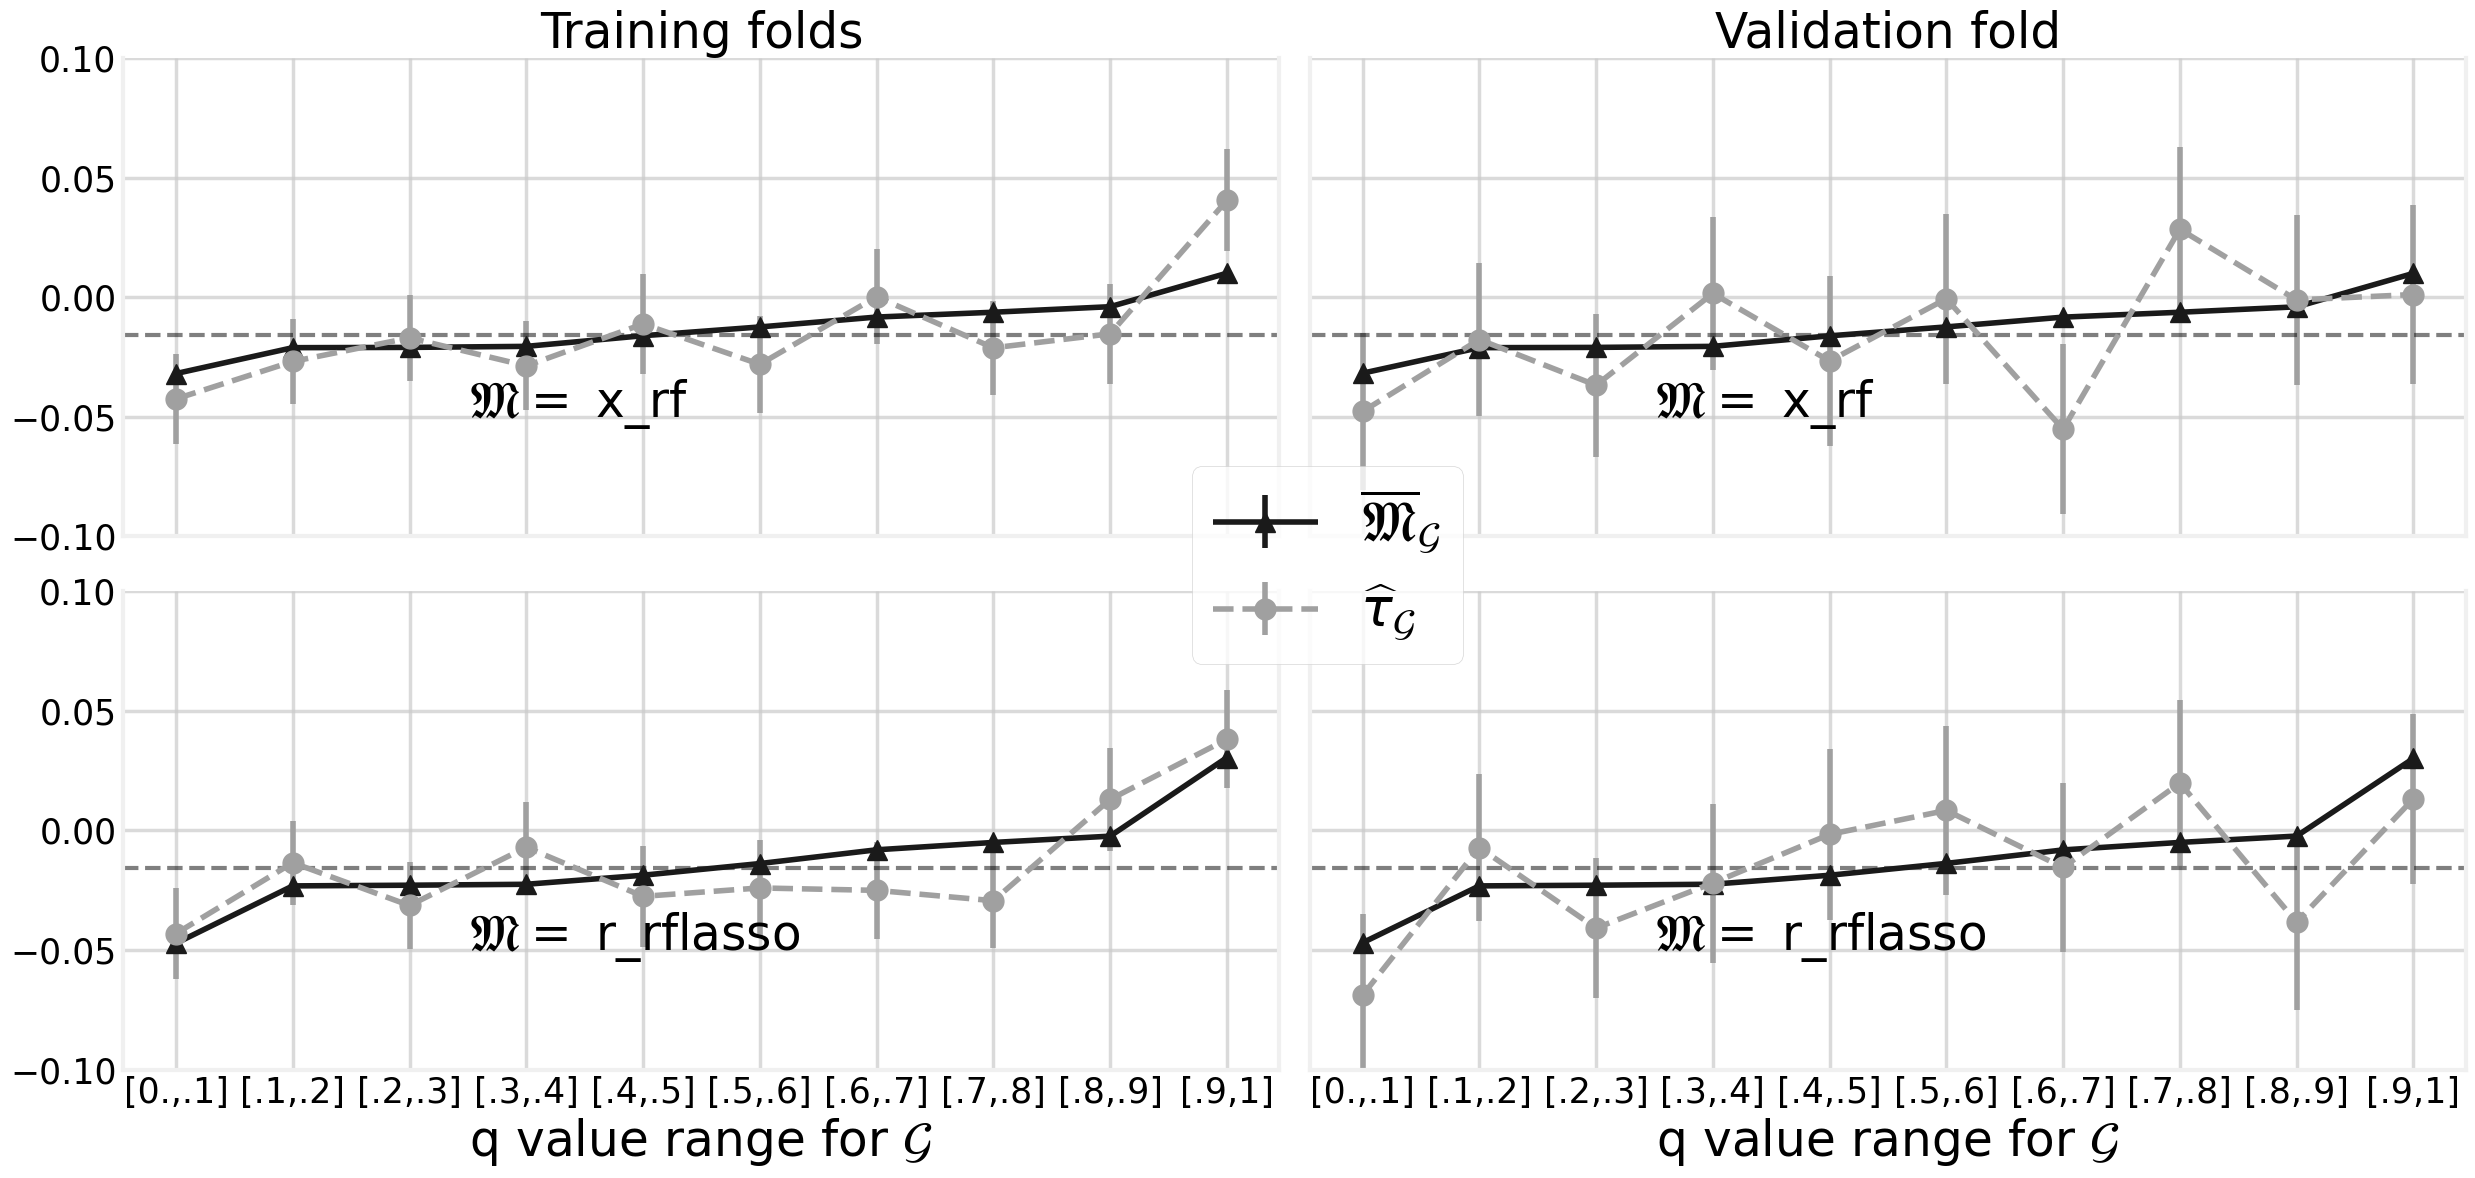

In [9]:
label_size = 35
tick_label_size = 25
mpl.rcParams['xtick.labelsize'] = tick_label_size 
mpl.rcParams['ytick.labelsize'] = tick_label_size
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size

xticks = ['[0.,.1]', '[.1,.2]', '[.2,.3]', '[.3,.4]', '[.4,.5]', '[.5,.6]', '[.6,.7]', '[.7,.8]', '[.8,.9]', '[.9,1]']
fig, axes = plt.subplots(2, 2, sharey = True, sharex=True, figsize = [25, 12])
axes = axes.flatten()
for j, estimator in enumerate(['x_rf', 'r_rflasso']):
    ax1, ax2 = axes[2*j], axes[2*j+1]
    for k, (lab, title, ax) in enumerate(zip(["train", "val"], 
                                             ["Training folds", "Validation fold"], 
                                             [ax1 ,ax2])):
        if j == 0:
            ax.set_title(title)
        # Plot model CATEs
        p1 = ax.errorbar(x = np.arange(0, n_bins), 
                    y = cal_plot_data[k][estimator]["model_CATEs"], 
                    yerr = cal_plot_data[k][estimator]["model_CATEs_std"],
                    marker= '^', markersize = 15,
                    linewidth = 4., linestyle='-', color=colors[0],
                    label = r'$\overline{\mathfrak{M}}_{\mathcal {G}}$')
        # Plot Neyman CATEs
        p2 = ax.errorbar(x = np.arange(0, n_bins), 
                    y = cal_plot_data[k][estimator]["Neyman_CATEs"],
                    yerr = cal_plot_data[k][estimator]["Neyman_CATEs_std"],
                    marker = 'o', markersize = 15,
                    linewidth = 4., linestyle='--', color=colors[6],
                    label = r'$\widehat{	au}_{\mathcal{G}}$')
        ax.text(x=2.5, y=-0.05, s= r'$\mathfrak{M}=$ ' + new_labels_dict[estimator], 
                fontsize=label_size)
        # Add line to indicate ATE
        ax.axhline(y = ATE, linestyle='--', color = 'k', linewidth = 3., alpha = 0.5)
        ax.set_ylim([-0.1, 0.1])
        # X labels and legend
        if j == 1:
            ax.set_xticks(np.arange(0, n_bins))
#             ax.set_xticklabels(cal_plot_data[k][estimator].index)
            ax.set_xticklabels(xticks)
            ax.set_xlabel(r"q value range for $\mathcal{G}$")
#         if j == 0:
#             if k == 0:
#                 ax.legend(fontsize = 45)

        ax.grid(True, alpha = 0.7)
#         ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
#         ax.spines['bottom'].set_visible(False)
# plt.suptitle("TC Events", y=1.01)
plt.tight_layout()
# Add legend
leg = fig.legend((p1, p2), (r'$\overline{\mathfrak{M}}_{\mathcal {G}}$', 
                            r'$\widehat{\tau}_{\mathcal{G}}$'), 
                 loc='center right', bbox_to_anchor=(0.6, 0.52), 
                 fontsize=38, frameon=True)
# leg.remove()
# if savfig:
#     plt.savefig(SAVE_PATH + f"{outcome_name}_x_rf_s_rf_calibration_plot_no_leg.pdf"
#                 , bbox_inches='tight')
# plt.show()

### 2.2. CR2 generalization scatter plots

In [10]:
# Get data to make plot
all_estimators = list(fitted_libraries["pert_none"].keys())
try:
    cr2_10r_plot_data, cr2_2r_plot_data = joblib.load(f"output/analysis/{outcome}/{outcome}_rscores_pert_none_only.pkl")
    # Ensure all selected estimators are present in the loaded data
    for est in selected_estimators:
        if est not in cr2_10r_plot_data:
            raise ValueError(f"Missing estimator {est} in cached data")
except:
    cr2_10r_plot_data = {}
    cr2_2r_plot_data = {}
    for estimator in all_estimators:
        # Using ONLY pert_none as requested, but keeping 10 bins
        # For cr2_10r (n_bins_selected = 10)
        df_10 = get_cr2_plot_data(fitted_libraries["pert_none"][estimator], 
                                  10, n_bins_selected = 10, dir_neg = dir_neg)
        # perturbation concatenations removed
        cr2_10r_plot_data[estimator] = df_10.reset_index(drop=True)

        # For cr2_2r (n_bins_selected = 2)
        df_2 = get_cr2_plot_data(fitted_libraries["pert_none"][estimator], 
                                 10, n_bins_selected = 2, dir_neg = dir_neg)
        # perturbation concatenations removed
        cr2_2r_plot_data[estimator] = df_2.reset_index(drop=True)
    
    joblib.dump([cr2_10r_plot_data, cr2_2r_plot_data], f"output/analysis/{outcome}/{outcome}_rscores_pert_none_only.pkl")

all_cr2_scores_val = pd.concat(cr2_10r_plot_data[estimator]["cr2_val"] 
                               for estimator in all_estimators)

all_cr2_scores_train = pd.concat(cr2_10r_plot_data[estimator]["cr2_train"] 
                               for estimator in all_estimators)

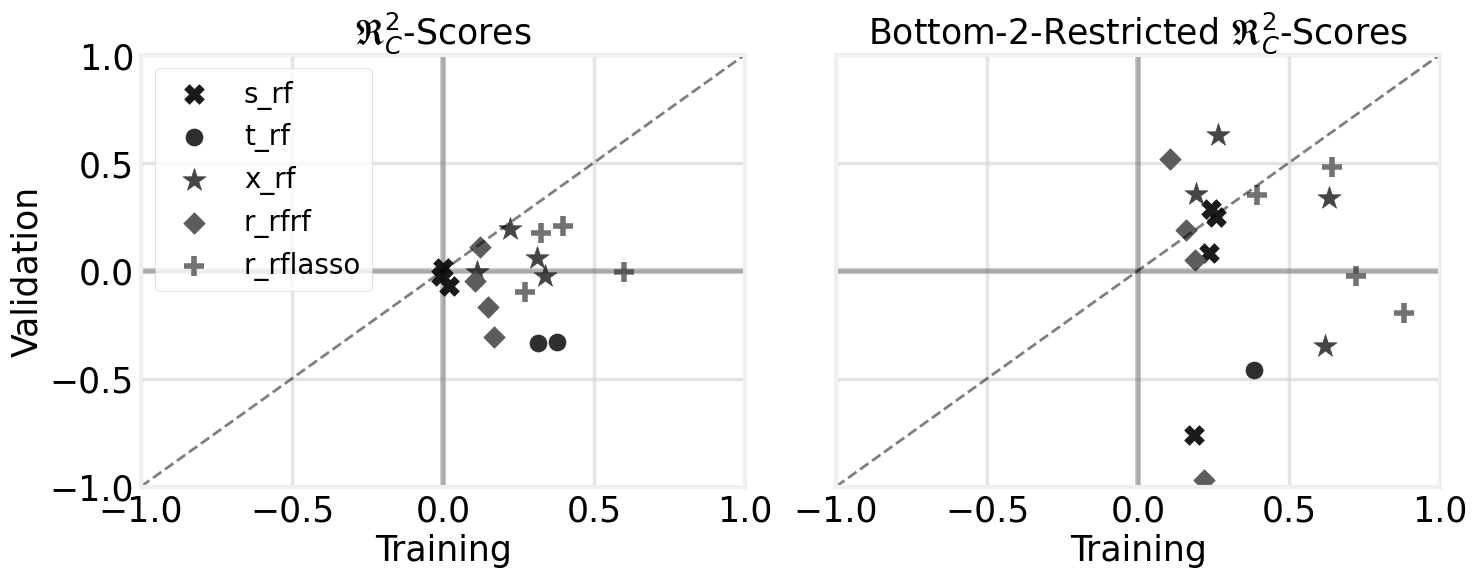

In [11]:
label_size = 25
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size
mss = ['X', 'o', '*', 'D', '+']
ms_size = [200, 150, 300, 120, 200]

f, (ax1, ax2) = plt.subplots(1, 2, sharey = True, sharex = True, 
                             figsize = [15, 6])

for i, estimator in enumerate(selected_estimators):
    ax1.scatter(cr2_10r_plot_data[estimator]["cr2_train"], 
                cr2_10r_plot_data[estimator]["cr2_val"], 
                label = new_labels_dict[estimator], marker = mss[i], 
                s=ms_size[i])
ax1.plot([-1, 1], [-1, 1], 'k--', alpha = 0.5, linewidth = 2.)
ax1.axhline(y = 0, color = 'k', alpha = .25)
ax1.axvline(x = 0, color = 'k', alpha = .25)
ax1.set_ylabel("Validation")
ax1.set_xlabel("Training")
ax1.set_title(r"$\mathfrak{R}_C^2$-Scores")
ax1.grid(True, alpha = 0.5)
ax1.legend(loc="upper left")

for i, estimator in enumerate(selected_estimators):
    ax2.scatter(cr2_2r_plot_data[estimator]["cr2_train"], 
                cr2_2r_plot_data[estimator]["cr2_val"], 
                label = estimator, marker = mss[i], s=ms_size[i])
ax2.plot([-1, 1], [-1, 1], 'k--', alpha = 0.5, linewidth = 2.)
ax2.axhline(y = 0, color = 'k', alpha = .25)
ax2.axvline(x = 0, color = 'k', alpha = .25)
ax2.set_xlabel("Training")
ax2.set_title(r"Bottom-2-Restricted $\mathfrak{R}_C^2$-Scores")
ax2.grid(True, alpha = 0.5)

plt.ylim([-1, 1])
plt.xlim([-1, 1])
plt.tight_layout()

savfig = False
if savfig:
    plt.savefig(SAVE_PATH + f"{outcome}_r2.pdf")
plt.show()

### 2.3. Aggregate R2 statistics

In [12]:
# Get data to make plot
all_estimators = list(fitted_libraries["pert_none"].keys())
try:
    cr2_plot_data = joblib.load(f"output/analysis/{outcome}/{outcome}_rscores_hist.pkl")
except:
    cr2_plot_data = {}
    for estimator in all_estimators:
        cr2_plot_data[estimator] = get_cr2_plot_data(fitted_libraries["pert_none"][estimator], 
                                                    n_bins, dir_neg=dir_neg)
        cr2_plot_data[estimator] = pd.concat([cr2_plot_data[estimator],
                                get_cr2_plot_data(fitted_libraries["pert_cv_0"][estimator], 
                                                n_bins, dir_neg=dir_neg)])
        cr2_plot_data[estimator] = pd.concat([cr2_plot_data[estimator],
                                get_cr2_plot_data(fitted_libraries["pert_cv_1"][estimator], 
                                                n_bins, dir_neg=dir_neg)])
        cr2_plot_data[estimator] = cr2_plot_data[estimator].reset_index() \
                                                        .drop(columns = ["index"])

    for estimator in all_estimators:
        cr2_plot_data[estimator] = cr2_plot_data[estimator].reset_index() \
                                                        .drop(columns = ["index"])

    joblib.dump(cr2_plot_data, f"output/analysis/{outcome}/{outcome}_rscores_hist.pkl")

all_cr2_scores_val = pd.concat(cr2_plot_data[estimator]["cr2_val"] 
                               for estimator in all_estimators)

all_cr2_scores_train = pd.concat(cr2_plot_data[estimator]["cr2_train"] 
                               for estimator in all_estimators)

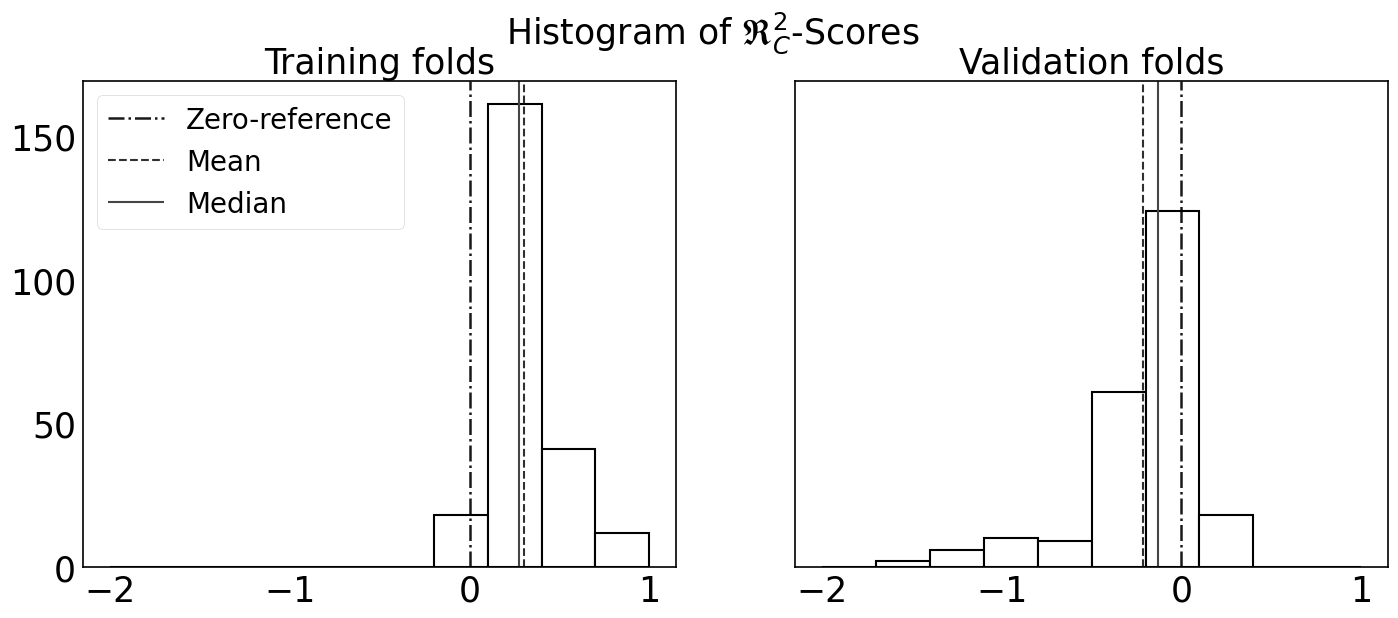

In [20]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey = True, sharex = True, figsize = [15, 6])

ax1.hist(all_cr2_scores_train, bins = np.linspace(-2,1,11), color='white', edgecolor='black', linewidth=1.5)
ax1.axvline(0, alpha=.9, color='k', linestyle='-.', linewidth=1.8,
           label="Zero-reference")
ax1.axvline(all_cr2_scores_train.mean(), linestyle='--', color=colors[1], alpha=1, linewidth=1.5,
            label="Mean")
ax1.axvline(all_cr2_scores_train.median(), linestyle='-', color=colors[2], alpha=1., linewidth=1.5,
            label="Median")
ax1.set_title("Training folds")
ax1.grid(False)
ax1.legend(fontsize=20)

ax2.hist(all_cr2_scores_val, bins = np.linspace(-2,1,11), color='white', edgecolor='black', linewidth=1.5)
ax2.axvline(0, alpha=.9, color='k', linestyle='-.', linewidth=1.8,
           label="O-reference")
ax2.axvline(all_cr2_scores_val.mean(), linestyle='--', color=colors[1], alpha=1,
            linewidth=1.5,
           label="Mean")
ax2.axvline(all_cr2_scores_val.median(), linestyle='-', color=colors[2], alpha=1,
            linewidth=1.5,
           label="Median")
ax2.grid(False)
ax2.set_title("Validation folds")

for axis in (ax1, ax2):
    for spine in axis.spines.values():
        spine.set_color('black')
        spine.set_linewidth(1.2)

plt.suptitle(r"Histogram of $\mathfrak{R}_C^2$-Scores",  y=1.0)

savfig = False
if savfig:
    plt.savefig(SAVE_PATH + f"{outcome}_distribution_r2.pdf")
plt.show()

In [55]:
print('Training mean:', all_cr2_scores_train.mean())
print('Training median:', all_cr2_scores_train.median())
print('Validation mean:', all_cr2_scores_val.mean())
print('Validation median:', all_cr2_scores_val.median())

Training mean: 0.3027403749014862
Training median: 0.2772589738361793
Validation mean: -0.21424733397184612
Validation median: -0.13174835916835725


In [56]:
get_cr2_plot_data(fitted_libraries["pert_none"]['x_lasso'], 10, dir_neg=dir_neg)

,cr2_train,cr2_val
0,0.267721,0.058891
1,0.130603,-0.106837
2,0.326257,-0.413717
3,0.014674,0.070720


In [57]:
all_estimators = np.array(list(fitted_libraries["pert_none"].keys()))
estimator_argsort = np.argsort([-cr2_plot_data[estimator]["cr2_val"].mean() 
                                for estimator in all_estimators])
all_estimators = all_estimators[estimator_argsort]

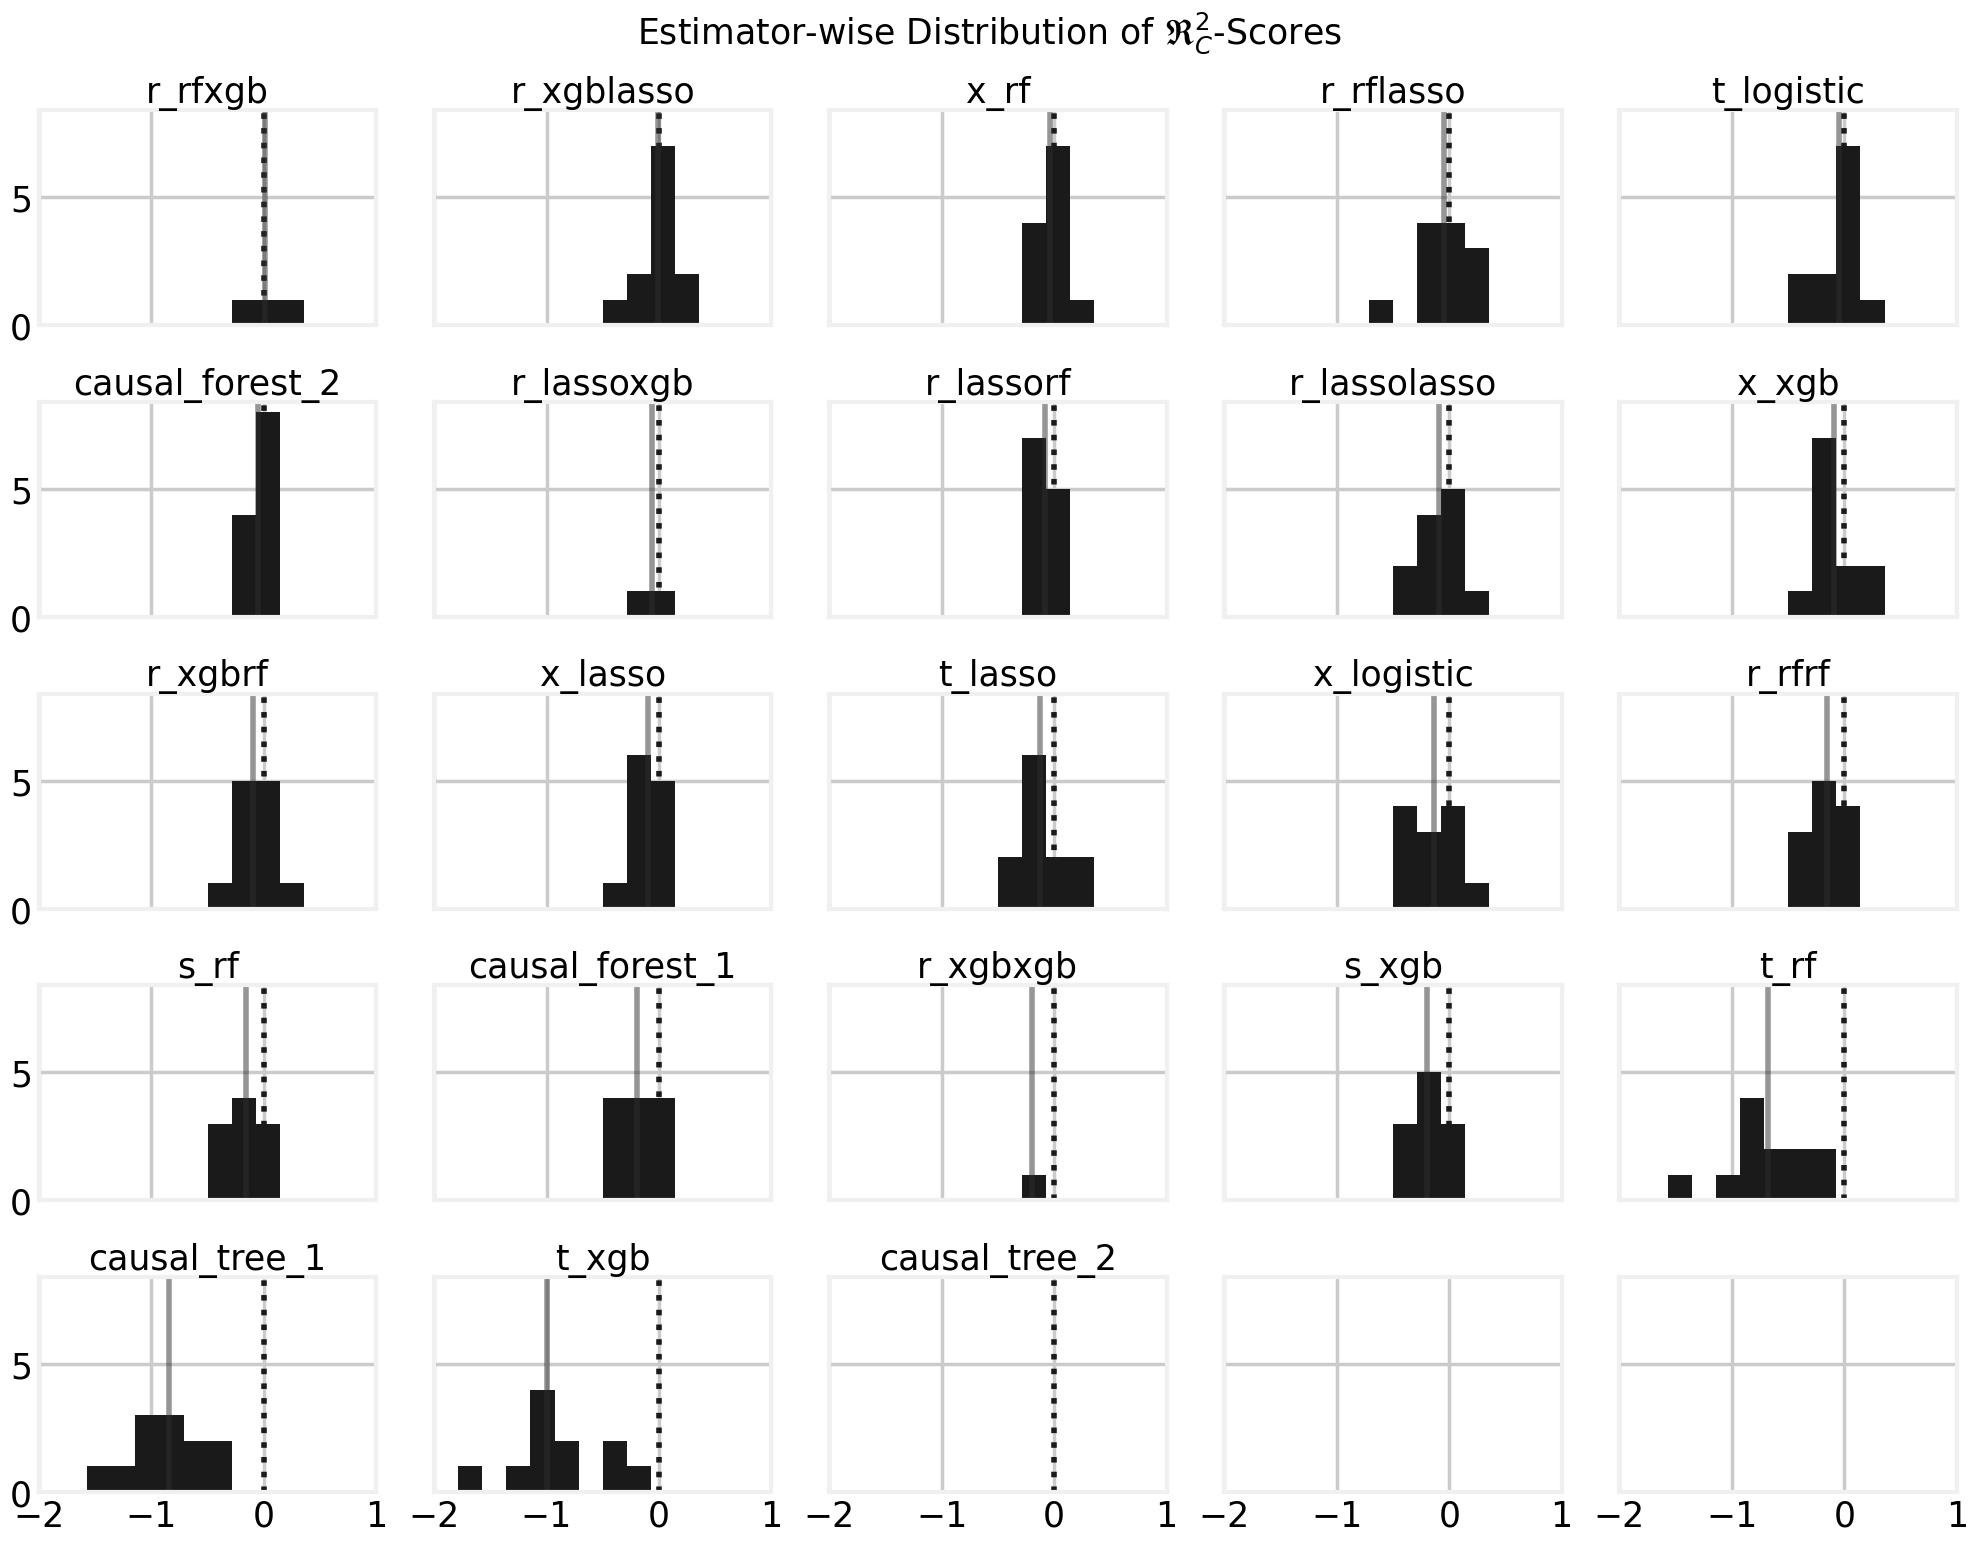

In [58]:
f, axes = plt.subplots(5, 5, figsize=[20, 15], sharex = True, sharey = True)
axes = axes.flatten()
for i, estimator in enumerate(all_estimators):
    ax = axes[i]
    ax.hist(cr2_plot_data[estimator]["cr2_val"], bins = np.linspace(-2,1,15))
    ax.axvline(0, alpha=1., linestyle=':')
    ax.axvline(cr2_plot_data[estimator]["cr2_val"].mean(), linestyle='-', 
               color=colors[1], alpha=0.5)
    ax.set_title(estimator)
    ax.set_xticks([-2, -1, 0, 1.])
    plt.xlim([-2, 1])
plt.tight_layout()
plt.suptitle(r"Estimator-wise Distribution of $\mathfrak{R}_C^2$-Scores", y = 1.03)
savfig = False
if savfig:
    plt.savefig(SAVE_PATH + f"{outcome}_estimator_wise_r2.pdf")
plt.show()

Takeaways: Poor prediction performance
1. Calibration plots show that the validation set is too small to accurately gauge prediction accuracy of CATE estimators.  
2. $C-R^2$ scatter plots show further evidence of overfitting. (training scores are systematically higher than validation scores).   
3. $C-R^2$ histograms show that across all estimators and 12 different training-validation data splits, the overwhelming majority of scores is less than 0.5,  
i.e. only reduces l1-variability by 50% from the ATE constant predictor baseline.

## 3. Monotonicity

- Top estimators are computed in 04a
- Refer to `06_plots` for the monotonicity boxplot

In [59]:
INTERMEDIATE_PATH = Path("output/intermediate/grid_search")
optimal_config_path = INTERMEDIATE_PATH / f"{outcome}_optimal_config.pkl"

optimal_config = joblib.load(optimal_config_path)
top_estimator_names = optimal_config["estimators"]
print(top_estimator_names)

['r_rflasso', 'r_xgblasso']


In [60]:
fitted_libraries = joblib.load(f"output/analysis/{outcome}/{outcome}_fitted_libraries.pkl")

### 3.1. Monotinicity with respect to 5 bins  

In [ ]:
monotonicity_df = get_monotonicity_results(fitted_libraries, top_estimator_names, 
                                            n_bins = 10, dir_neg = dir_neg)
joblib.dump(monotonicity_df, f"output/analysis/{outcome}/{outcome}_monotonicity_df.pkl")

In [ ]:
monotonicity_df

,"[0.5,0.6] vs [0.6, 0.6]","[0.6,0.6] vs [0.6, 0.7]","[0.6,0.7] vs [0.7, 0.7]","[0.7,0.7] vs [0.7, 0.8]","[0.7,0.8] vs [0.8, 0.8]","[0.8,0.8] vs [0.8, 0.9]","[0.8,0.9] vs [0.9, 0.9]","[0.9,0.9] vs [0.9, 0.9]","[0.9,0.9] vs [0.9, 1.0]",last_bin_is_max
s_xgb,0.416667,0.166667,0.666667,0.750000,0.333333,0.416667,0.333333,0.583333,0.333333,0.083333
s_rf,0.333333,0.500000,0.416667,0.333333,0.250000,0.500000,0.083333,0.916667,0.333333,0.000000
t_lasso,0.416667,0.500000,0.500000,0.666667,0.583333,0.416667,0.583333,0.750000,0.666667,0.083333
t_logistic,0.333333,0.583333,0.500000,0.583333,0.500000,0.333333,0.666667,0.833333,0.500000,0.000000
t_rf,0.666667,0.583333,0.500000,0.583333,0.416667,0.583333,0.583333,0.500000,0.500000,0.333333
t_xgb,0.666667,0.333333,0.583333,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.083333
x_lasso,0.500000,0.666667,0.500000,0.583333,0.583333,0.416667,0.666667,0.750000,0.750000,0.083333
x_logistic,0.333333,0.583333,0.500000,0.666667,0.416667,0.333333,0.500000,0.666667,0.750000,0.083333
x_rf,0.583333,0.250000,0.583333,0.416667,0.500000,0.500000,0.333333,0.750000,0.583333,0.250000
x_xgb,0.583333,0.333333,0.500000,0.583333,0.416667,0.416667,0.583333,0.583333,0.750000,0.083333


Remark: Top estimators determined using the methodology in notebook 04a.

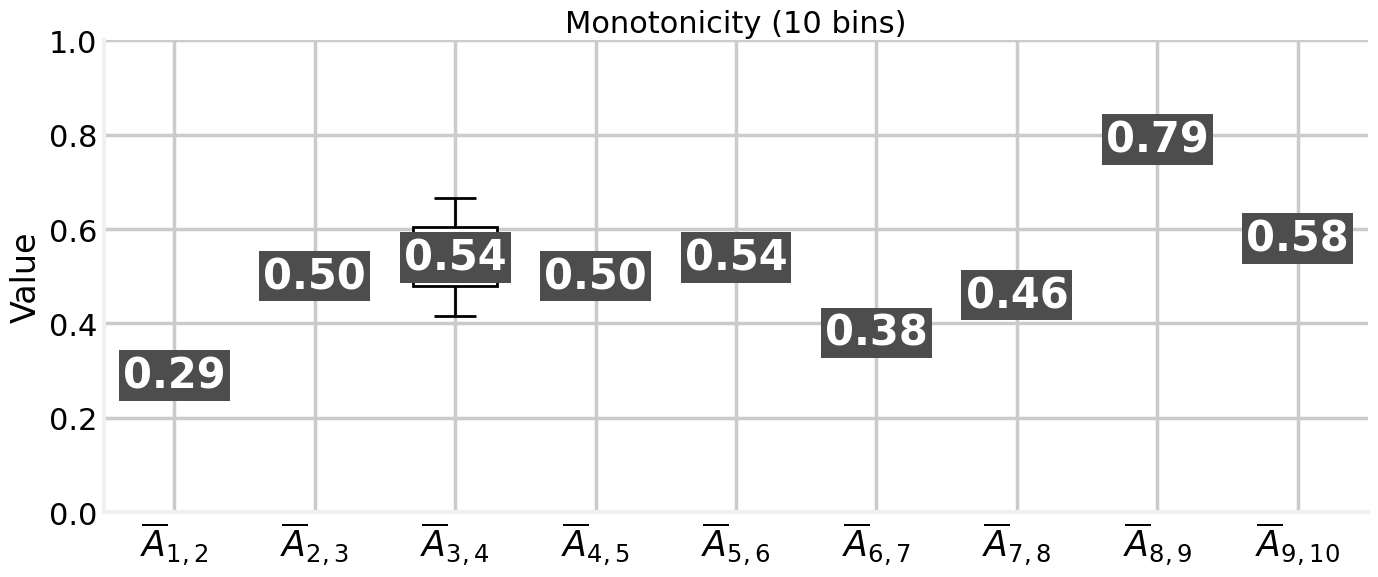

In [ ]:
label_size = 22
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size

stick = 'A'
ticks1 = [r'$\overline{%s}_{%d,%d}$'%(stick, i, i+1) for i in range(1, 10)]

# Single plot using monotonicity_df only
f, ax = plt.subplots(1, 1, figsize=[14, 6])

plot_df = monotonicity_df.drop(index=["mean", "top6_mean"], errors="ignore")
top6 = top_estimator_names
plot_df = plot_df.loc[plot_df.index.intersection(top6)]
# Remove last column (last_bin_is_max)
plot_df = plot_df.iloc[:, :-1]

box_plot = sns.boxplot(
    data=plot_df,
    ax=ax,
    fliersize=10,
    linewidth=2,
    width=.6,
    color='white',
    boxprops=dict(facecolor='white', edgecolor='black', linewidth=2),
    whiskerprops=dict(color='black', linewidth=2),
    capprops=dict(color='black', linewidth=2),
    medianprops=dict(color='black', linewidth=2),
    flierprops=dict(marker='o', markerfacecolor='white', markeredgecolor='black', markersize=6)
)


# Ticks, labels, style
ax.set_xticklabels(ticks1, fontsize=25)
ax.grid(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("Monotonicity (10 bins)")
ax.set_ylabel("Value", fontsize=24)
ax.set_ylim(0, 1)

try:
    lines = ax.get_lines()
    categories = range(len(plot_df.columns))
    for cat in categories:
        median_line = lines[4 + cat*6]
        y = round(median_line.get_ydata()[0], 2)
        ax.text(
            cat,
            y,
            f"{y:.2f}",
            ha="center",
            va="center",
            fontweight="bold",
            size=30,
            color="white",
            bbox=dict(facecolor=annotation_box_color, edgecolor='none', pad=3)
        )
except Exception as e:
    print(f"Note: Annotation skipped for some boxes: {e}")


plt.tight_layout()

savfig = False
if savfig:
    plt.savefig(SAVE_PATH + f"{outcome}_monotonicity_box_plot.pdf")
plt.show()

### 3.2. Comparing quantile-based top subgroup with its complement

In [ ]:
new_monotonicity_df = get_monotonicity_results(fitted_libraries, top_estimator_names=top_estimator_names,
                                                q_values=q_values, dir_neg=dir_neg)
joblib.dump(new_monotonicity_df, f"output/analysis/{outcome}/{outcome}_new_monotonicity_df.pkl")

['output/analysis/fausebal/fausebal_new_monotonicity_df.pkl']

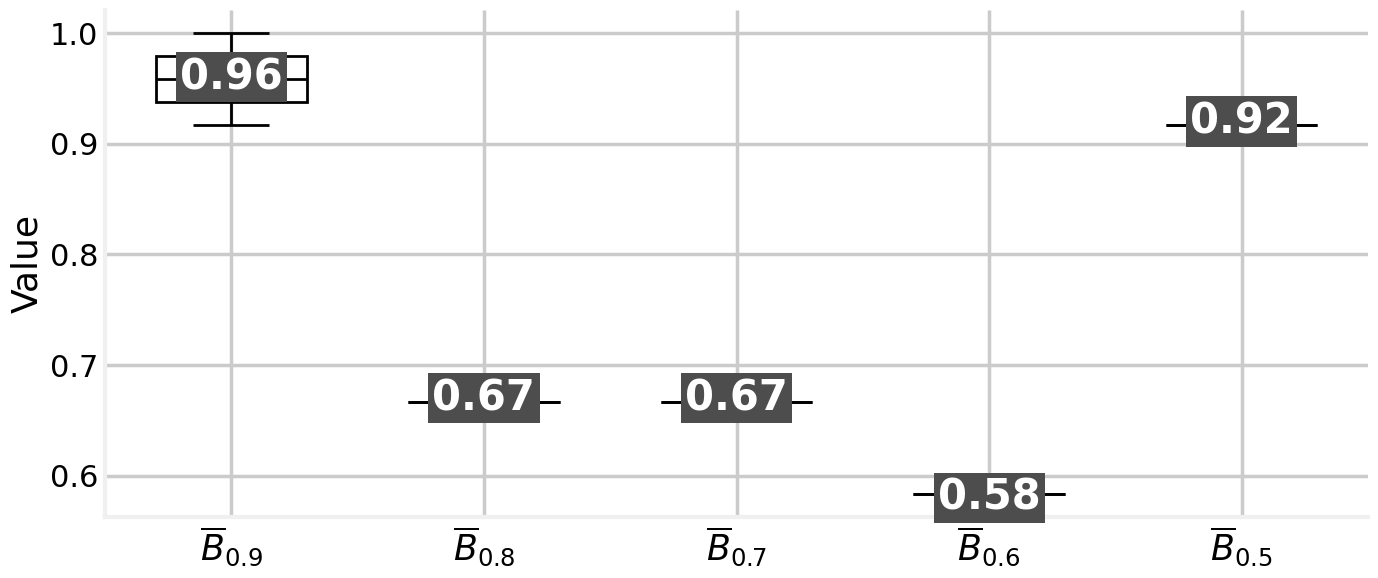

In [ ]:
# Tick labels for TC (quantile-based)
stick = 'B'
qs = [0.1, 0.2, 0.3, 0.4, 0.5]
# Complement quantiles for TC; use f-strings with explicit braces for mathtext
ticks2 = [rf'$\overline{{{stick}}}_{{{1-q:.1f}}}$' for q in qs]
# TC-only monotonicity boxplot (quantile-based)
f, ax1 = plt.subplots(1, 1, figsize = [14, 6])

ax = ax1
top6 = top_estimator_names
plot_df = new_monotonicity_df.drop(index={"mean", "top6_mean"}, errors="ignore")
plot_df = plot_df.loc[plot_df.index.intersection(top6)]

box_plot = sns.boxplot(
    data=plot_df,
    ax=ax,
    fliersize=10,
    linewidth=2,
    width=.6,
    color='white',
    boxprops=dict(facecolor='white', edgecolor='black', linewidth=2),
    whiskerprops=dict(color='black', linewidth=2),
    capprops=dict(color='black', linewidth=2),
    medianprops=dict(color='black', linewidth=2),
    flierprops=dict(marker='o', markerfacecolor='white', markeredgecolor='black', markersize=6)
)

ax.set_xticks(np.arange(len(ticks2)))
ax.set_xticklabels(ticks2, fontsize=25)
ax.grid(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax1.set_ylabel("Value", fontsize=26)
try:
    lines = ax.get_lines()
    categories = range(len(plot_df.columns))
    for cat in categories:
        median_line = lines[4 + cat*6]
        y = round(median_line.get_ydata()[0], 2)
        ax.text(
            cat,
            y,
            f"{y:.2f}",
            ha="center",
            va="center",
            fontweight="bold",
            size=30,
            color="white",
            bbox=dict(facecolor=annotation_box_color, edgecolor='none', pad=3)
        )
except Exception as e:
    print(f"Note: Annotation skipped for some boxes: {e}")

# plt.suptitle("Quantile-based Top Subgroup Comparison Scores", x=.55, y=1.03)
plt.tight_layout()

savfig = False
if savfig:
    plt.savefig("figs/TC_new_monotonicity_box_plot.pdf", bbox_inches='tight')
plt.show()


In [ ]:
# Generate all_mono_df if not defined
try:
    all_mono_df = joblib.load(f"output/analysis/{outcome}/{outcome}_all_monotonicity_df.pkl")
except:
    # Generate for all estimators (q_values=qs)
    # Ensure qs is defined before this or pass it explicitly if known, 
    # but qs is usually defined in specific cells. 
    # Actually qs is defined in the plotting cell BELOW this insertion point. 
    # Safest to define qs here too just in case.
    qs_local = [0.1, 0.2, 0.3, 0.4, 0.5]
    all_mono_df = get_monotonicity_results(fitted_libraries, q_values=qs_local, dir_neg=dir_neg)
    joblib.dump(all_mono_df, f"output/analysis/{outcome}/{outcome}_all_monotonicity_df.pkl")


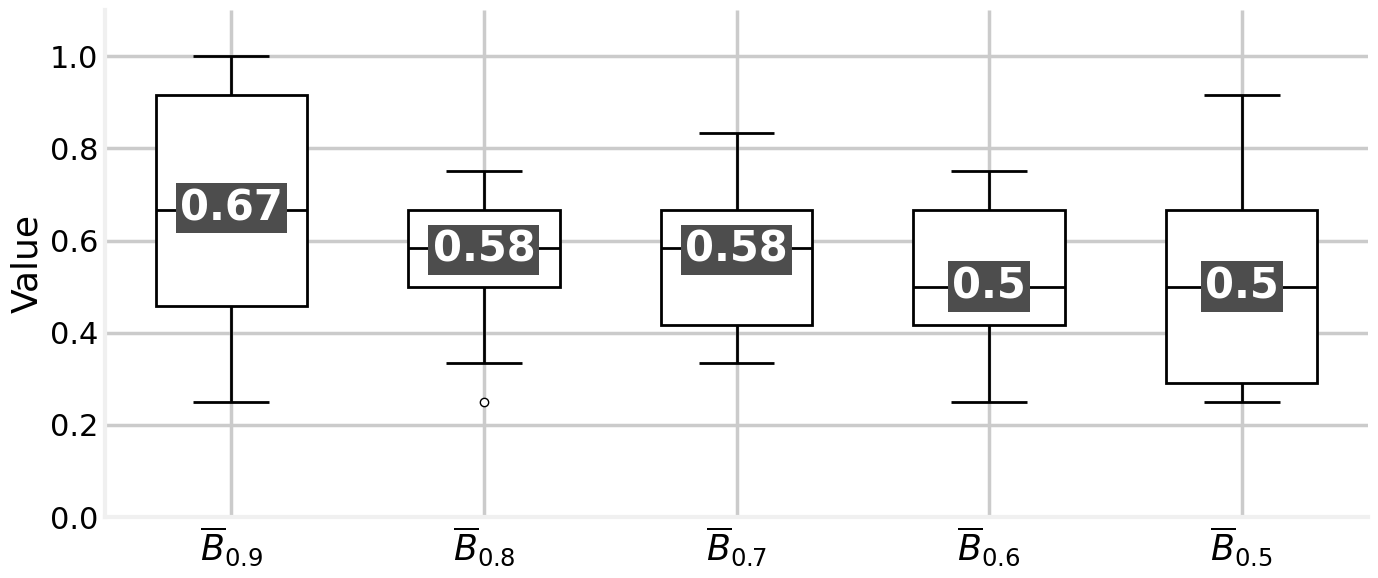

In [ ]:
# 3. Create Plot with Reference Style
# Tick labels for TC (quantile-based)
stick = 'B'
qs = [0.1, 0.2, 0.3, 0.4, 0.5]
# Complement quantiles for TC; use f-strings with explicit braces for mathtext
ticks2 = [rf'$\overline{{{stick}}}_{{{1-q:.1f}}}$' for q in qs]

# All Estimators monotonicity boxplot
f, ax1 = plt.subplots(1, 1, figsize = [14, 6])

ax = ax1
# Data preparation
plot_df = all_mono_df.drop(index=["mean", "top6_mean"], errors="ignore")

box_plot = sns.boxplot(
    data=plot_df,
    ax=ax,
    fliersize=10,
    linewidth=2,
    width=.6,
    color='white',
    boxprops=dict(facecolor='white', edgecolor='black', linewidth=2),
    whiskerprops=dict(color='black', linewidth=2),
    capprops=dict(color='black', linewidth=2),
    medianprops=dict(color='black', linewidth=2),
    flierprops=dict(marker='o', markerfacecolor='white', markeredgecolor='black', markersize=6)
)

# Add median labels on boxes
lines = ax.get_lines()
categories = ax.get_xticks()
try:
    for cat in categories:
        y = round(lines[4 + cat*6].get_ydata()[0], 2)
        ax.text(
            cat,
            y,
            f"{y}",
            ha="center",
            va="center",
            fontweight="bold",
            size=30,
            color="white",
            bbox=dict(facecolor=annotation_box_color, edgecolor='none', pad=3)
        )
except Exception as e:
    print(f"Note: Annotation skipped for some boxes: {e}")

# Ticks, limits, labels
ax.set_ylim((0, 1.1))
ax.set_xticks(np.arange(len(ticks2)))
ax.set_xticklabels(ticks2, fontsize=25)
ax.grid(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax1.set_ylabel("Value", fontsize=26)
# Title
# plt.suptitle("Monotonicity (All Estimators)", x=.55, y=1.03, fontsize=20)
plt.tight_layout()

if 'savfig' in locals() and savfig:
    plt.savefig(SAVE_PATH + "monotonicity_all_estimators_boxplot.pdf", bbox_inches='tight')
plt.show()

## 4. Stability of CATE estimators

### 4.1. Stability of quantile-based top subgroup

In this section, we examine the stability of the quantile-based subgroups by generalizing the notion of overlap.  
We consider the quantile-based top subgroup for q=0.2, and compute what percentage of its members are contained  
in the quantile-based top subgroup for other values of q, when the two subgroups are obtained from CATE estimators  
trained on different data splits.

In [ ]:
library_names = ["pert_none", "pert_cv_0", "pert_cv_1"]
library = {}
for estimator_name in fitted_libraries["pert_none"].keys():
    list_of_estimators = []
    for library_name in library_names:
        list_of_estimators.append(fitted_libraries[library_name][estimator_name])
    library[estimator_name] = combine_estimator_versions(list_of_estimators)
stability_scores = {}
q0 = 0.1
q_values_v2 = [0.1, 0.2, 0.3, 0.4, 0.5]
for estimator_name, estimator in library.items():
    stability_scores[estimator_name] = get_top_subgroup_stability(estimator, q0, q_values_v2, dir_neg).round(2)

In [ ]:
same_q_scores = []
diff_q_scores = []
for scores in stability_scores.values():
    same_q_scores.append(scores.loc[0.2,"mean coverage"])
    diff_q_scores.append(scores.loc[0.3,"mean coverage"])
scores_df = pd.DataFrame({"estimator" : list(stability_scores.keys()),
                          "0.2" : same_q_scores,
                          "0.3" : diff_q_scores})
scores_df = scores_df.set_index("estimator")
scores_df.drop(index = ["r_lassoxgb"], inplace = True)

In [ ]:
scores_df

,0.2,0.3
estimator,,
s_xgb,0.56,0.76
s_rf,0.63,0.69
t_lasso,0.80,0.85
t_logistic,0.81,0.85
t_rf,0.71,0.80
t_xgb,0.70,0.81
x_lasso,0.79,0.85
x_logistic,0.79,0.86
x_rf,0.73,0.83


### 4.2. Overlaps of quantile-based subgroups

In [ ]:
all_overlaps = get_overlap_values(fitted_libraries, 0.9, 1.0, compare_across = "all")

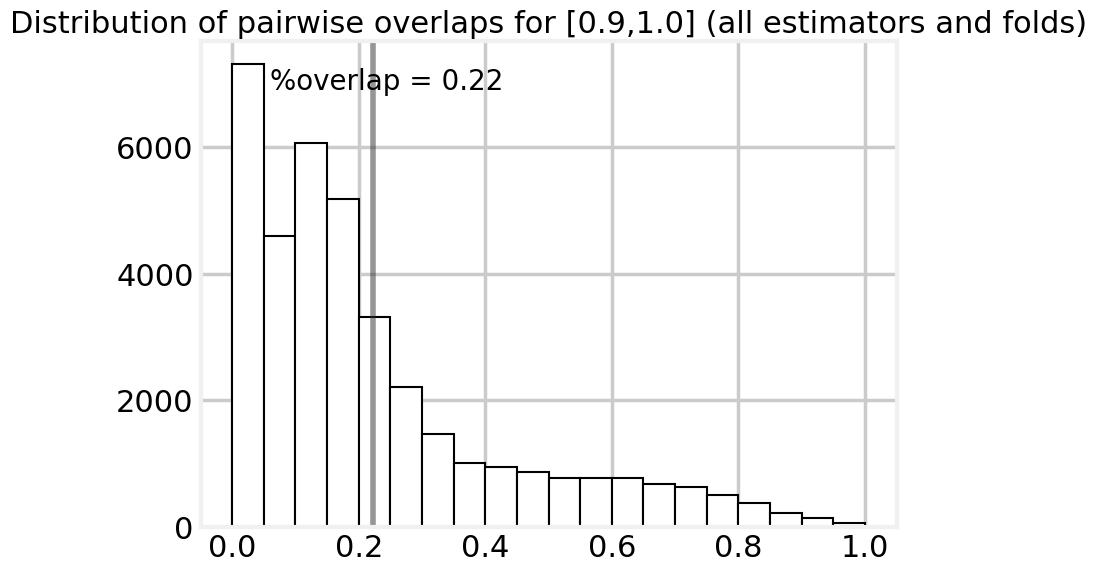

In [ ]:
plt.hist(all_overlaps, bins = 20, color='white', edgecolor='black', linewidth=1.5, zorder = 1)
plt.title("Distribution of pairwise overlaps for [0.9,1.0] (all estimators and folds)")
mean_overlap = all_overlaps.mean()
plt.axvline(x = mean_overlap, linestyle='-', color=colors[1], alpha=0.5, zorder = 2)
ax = plt.gca()
plt.annotate("%overlap = {:.2f}".format(mean_overlap),
             xy = (0.1, 0.9), xycoords = ax.transAxes,
             fontsize = 20)
plt.show()

In [ ]:
estimator_overlaps = get_overlap_values(fitted_libraries, 0.9, 1.0, compare_across = "estimators", fold = 0)

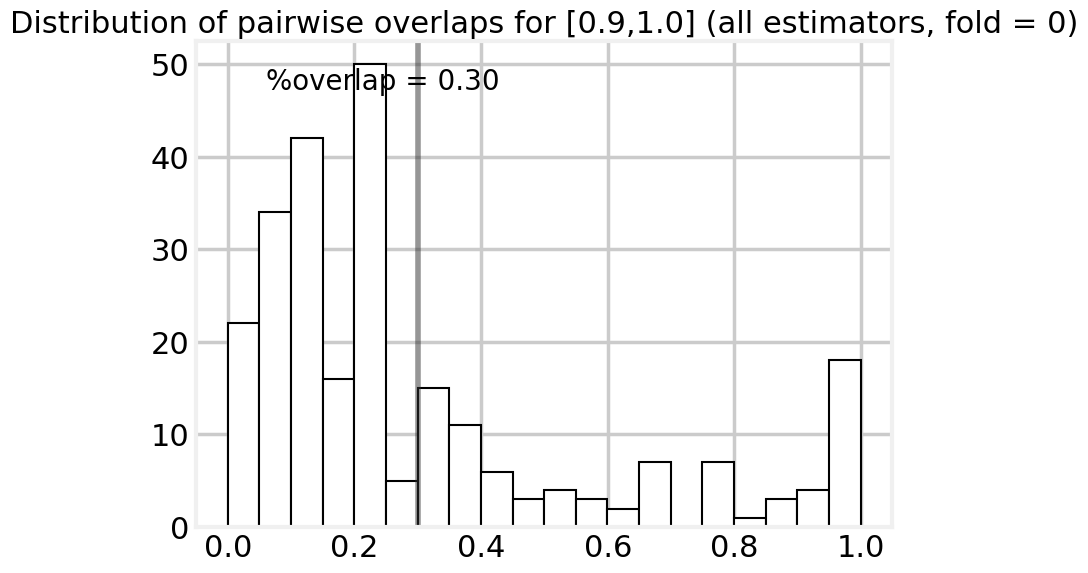

In [ ]:
plt.hist(estimator_overlaps, bins = 20, color='white', edgecolor='black', linewidth=1.5, zorder = 1)
plt.title("Distribution of pairwise overlaps for [0.9,1.0] (all estimators, fold = 0)")
mean_overlap = estimator_overlaps.mean()
plt.axvline(x = mean_overlap, linestyle='-', color=colors[1], alpha=0.5, zorder = 2)
ax = plt.gca()
plt.annotate("%overlap = {:.2f}".format(mean_overlap),
             xy = (0.1, 0.9), xycoords = ax.transAxes,
             fontsize = 20)
plt.show()

In [ ]:
# Get data to make plot
selected_estimators = list(fitted_libraries["pert_none"].keys())
selected_estimators.remove("r_lassoxgb")
overlap_plot_data = {}
for estimator in selected_estimators:
    overlap_plot_data[estimator] = get_overlap_values(fitted_libraries, 0.9, 1.0,
                                                      compare_across = "folds",
                                                      estimator = estimator)
# Order the estimators in decreasing order w.r.t. mean overlap
selected_estimators = np.array(selected_estimators)
estimator_argsort = np.argsort([-overlap_plot_data[estimator].mean() for estimator in selected_estimators])
selected_estimators = selected_estimators[estimator_argsort]

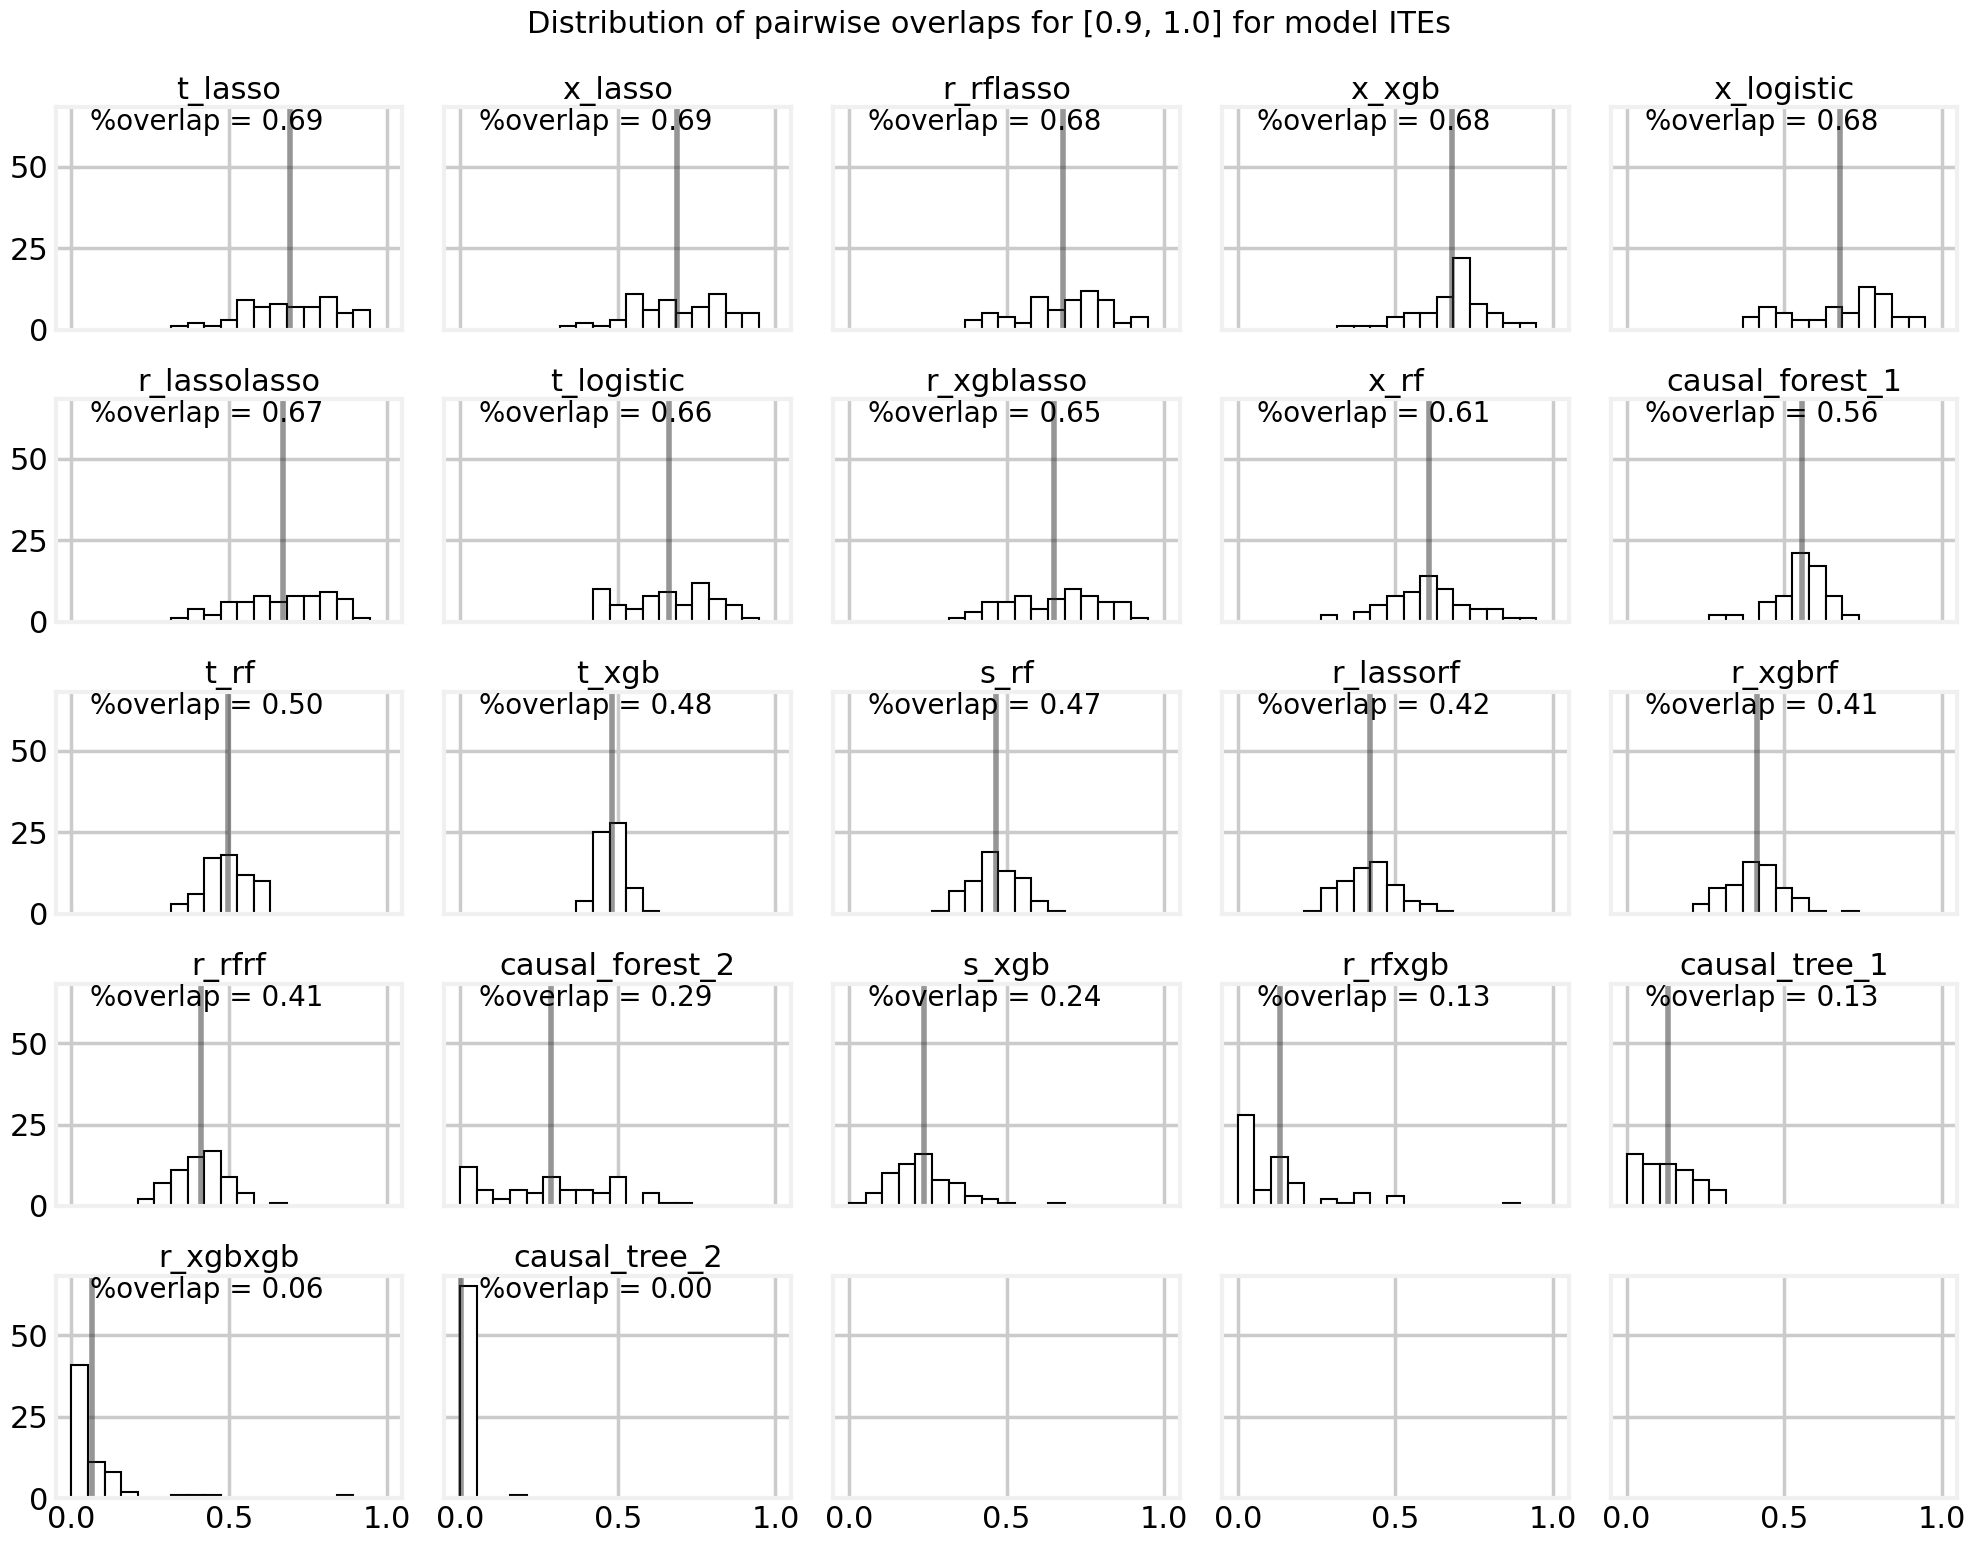

In [ ]:
f, axes = plt.subplots(5, 5, figsize=[20, 15], sharex = True, sharey = True)
axes = axes.flatten()
for i, estimator in enumerate(selected_estimators):
    ax = axes[i]
    ax.hist(overlap_plot_data[estimator], bins = np.linspace(0, 1, 20), color='white', edgecolor='black', linewidth=1.5)
    mean_overlap = overlap_plot_data[estimator].mean()
    ax.axvline(mean_overlap, linestyle='-', color=colors[1], alpha=0.5)
    ax.annotate("%overlap = {:.2f}".format(mean_overlap),
                xy = (.1, .9), xycoords = ax.transAxes,
                fontsize = 20)
    ax.set_title(estimator)
#    ax.set_xticks([-2, -1, 0, 1.])
#    plt.xlim([-2, 1])
plt.tight_layout()
plt.suptitle("Distribution of pairwise overlaps for [0.9, 1.0] for model ITEs", y = 1.03)
plt.show()

### 4.3. Aggregate correlation statistics

In [ ]:
all_correlations = get_r_values(fitted_libraries, compare_across = "all")
#all_correlations = all_correlations[~np.isnan(all_correlations)] In case of nan

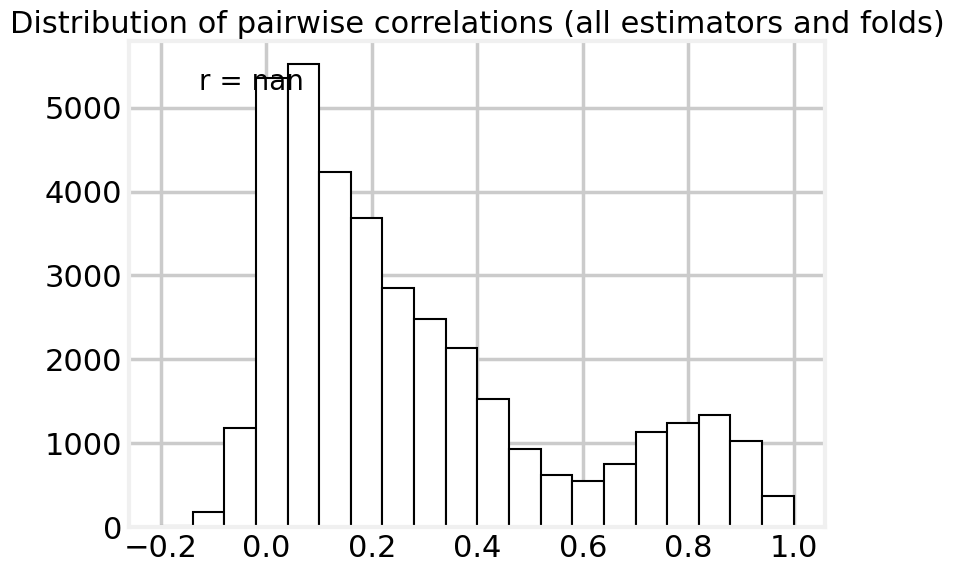

In [ ]:
plt.hist(all_correlations, bins = 20, color='white', edgecolor='black', linewidth=1.5, zorder = 1)
plt.title("Distribution of pairwise correlations (all estimators and folds)")
mean_r = all_correlations.mean()
plt.axvline(x = mean_r, linestyle='-', color=colors[1], alpha=0.5, zorder = 2)
ax = plt.gca()
plt.annotate("r = {:.2f}".format(mean_r),
             xy = (0.1, 0.9), xycoords = ax.transAxes,
             fontsize = 20)
plt.show()

### 4.4. Pairwise correlation for a single estimator when trained on different splits

In [ ]:
marker_size = 20
alpha = 0.3

def make_model_CATE_pairplot(estimator, estimator_name = None):
    model_CATEs_df = pd.DataFrame({})
    for fold_no, result in estimator.results.items():
        model_CATEs_df[fold_no] = result.tau
    def corrfunc(x, y, **kwargs):
        r, _ = stats.pearsonr(x, y)
        ax = plt.gca()
        ax.annotate("r = {:.2f}".format(r),
                    xy = (.1, .9), xycoords = ax.transAxes,
                    fontsize = 20)
    scatter_kwargs = {
        "s": marker_size,
        "alpha": alpha,
        "color": grayscale_palette[2]
    }
    diag_kwargs = {
        "color": 'white',
        "edgecolor": 'black',
        "linewidth": 1.0
    }
    g = sns.pairplot(model_CATEs_df, kind = "scatter", plot_kws = scatter_kwargs,
                      diag_kws = diag_kwargs, diag_kind = "hist")
    g = g.map_upper(corrfunc)
    g.fig.set_size_inches(15,15)
    title_string = "Pair plot for ITEs predicted by estimator when trained on 4 different folds"
    if estimator_name is not None:
        title_string += f": {estimator_name}"
    plt.suptitle(title_string, y = 1.03)
    plt.show()

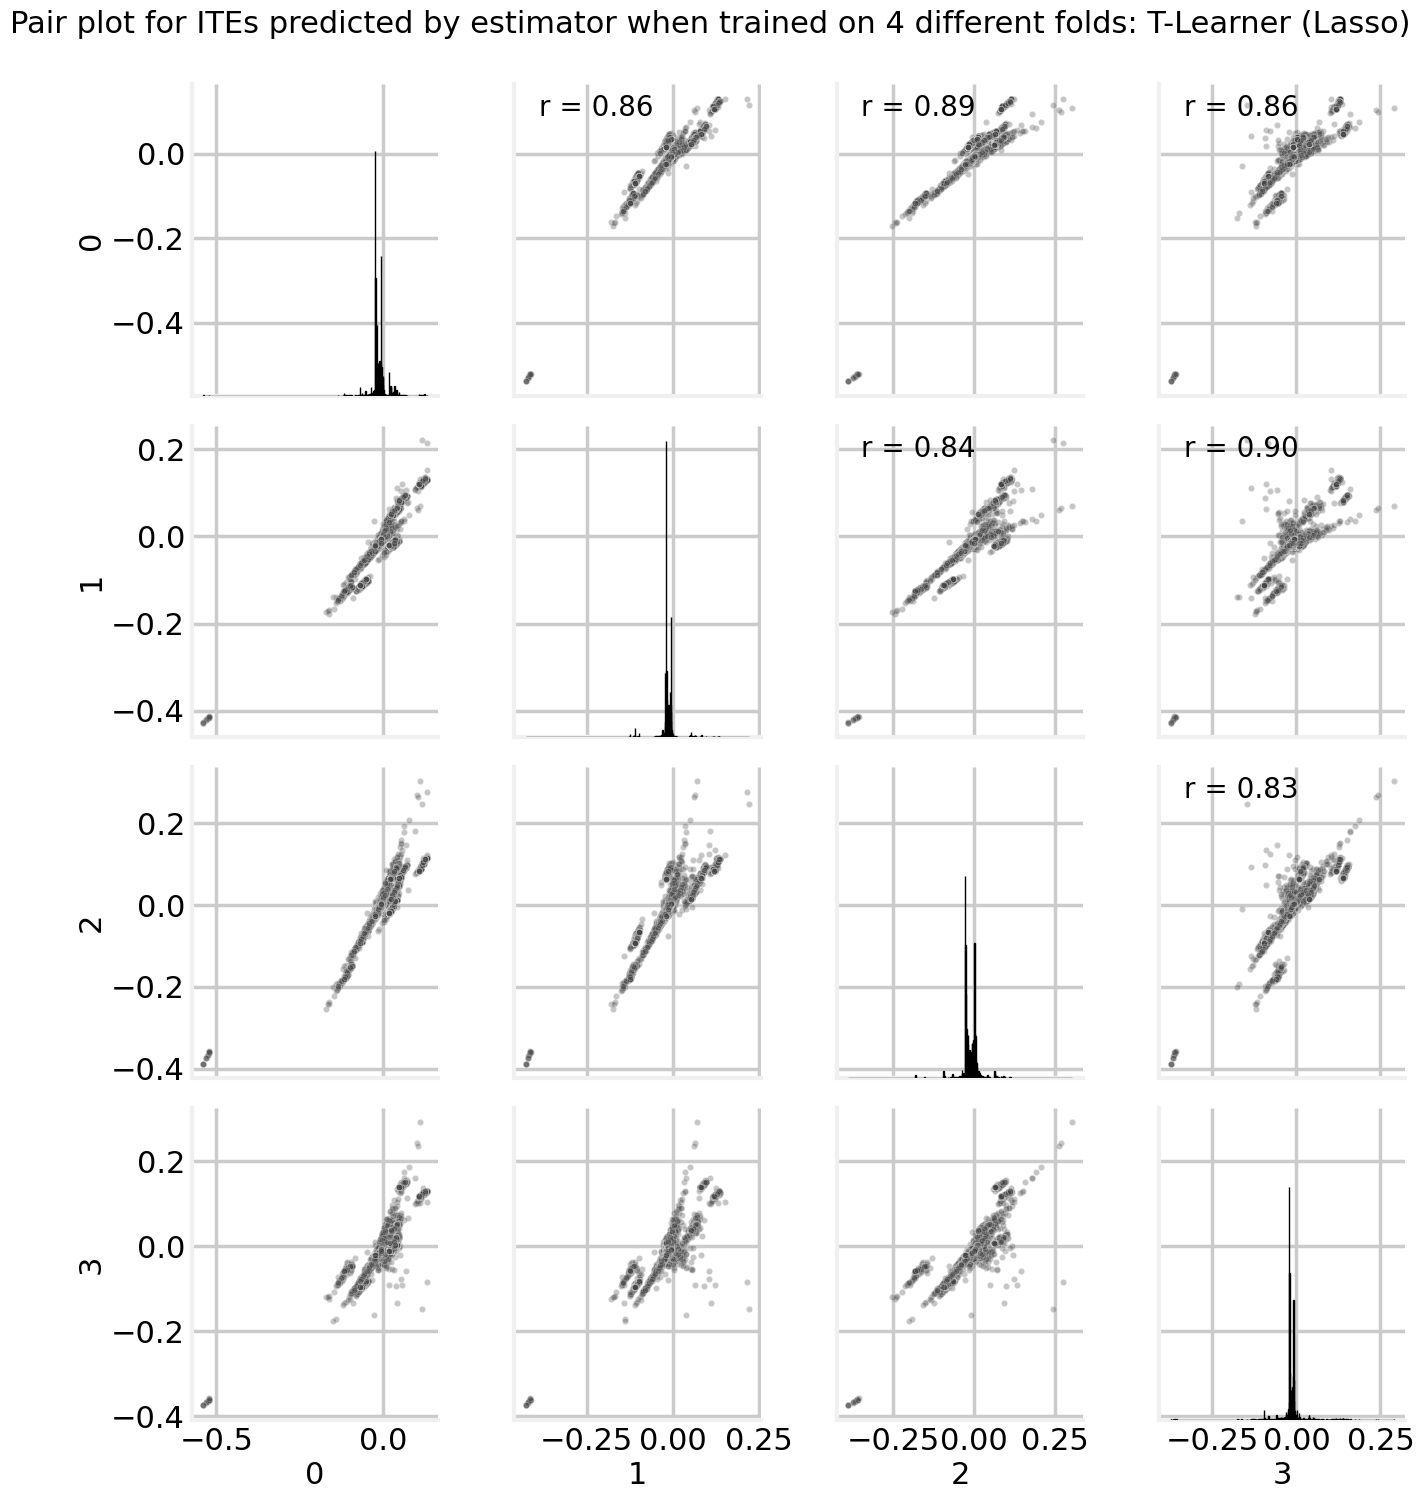

In [ ]:
make_model_CATE_pairplot(fitted_libraries["pert_none"]["t_lasso"], "T-Learner (Lasso)")

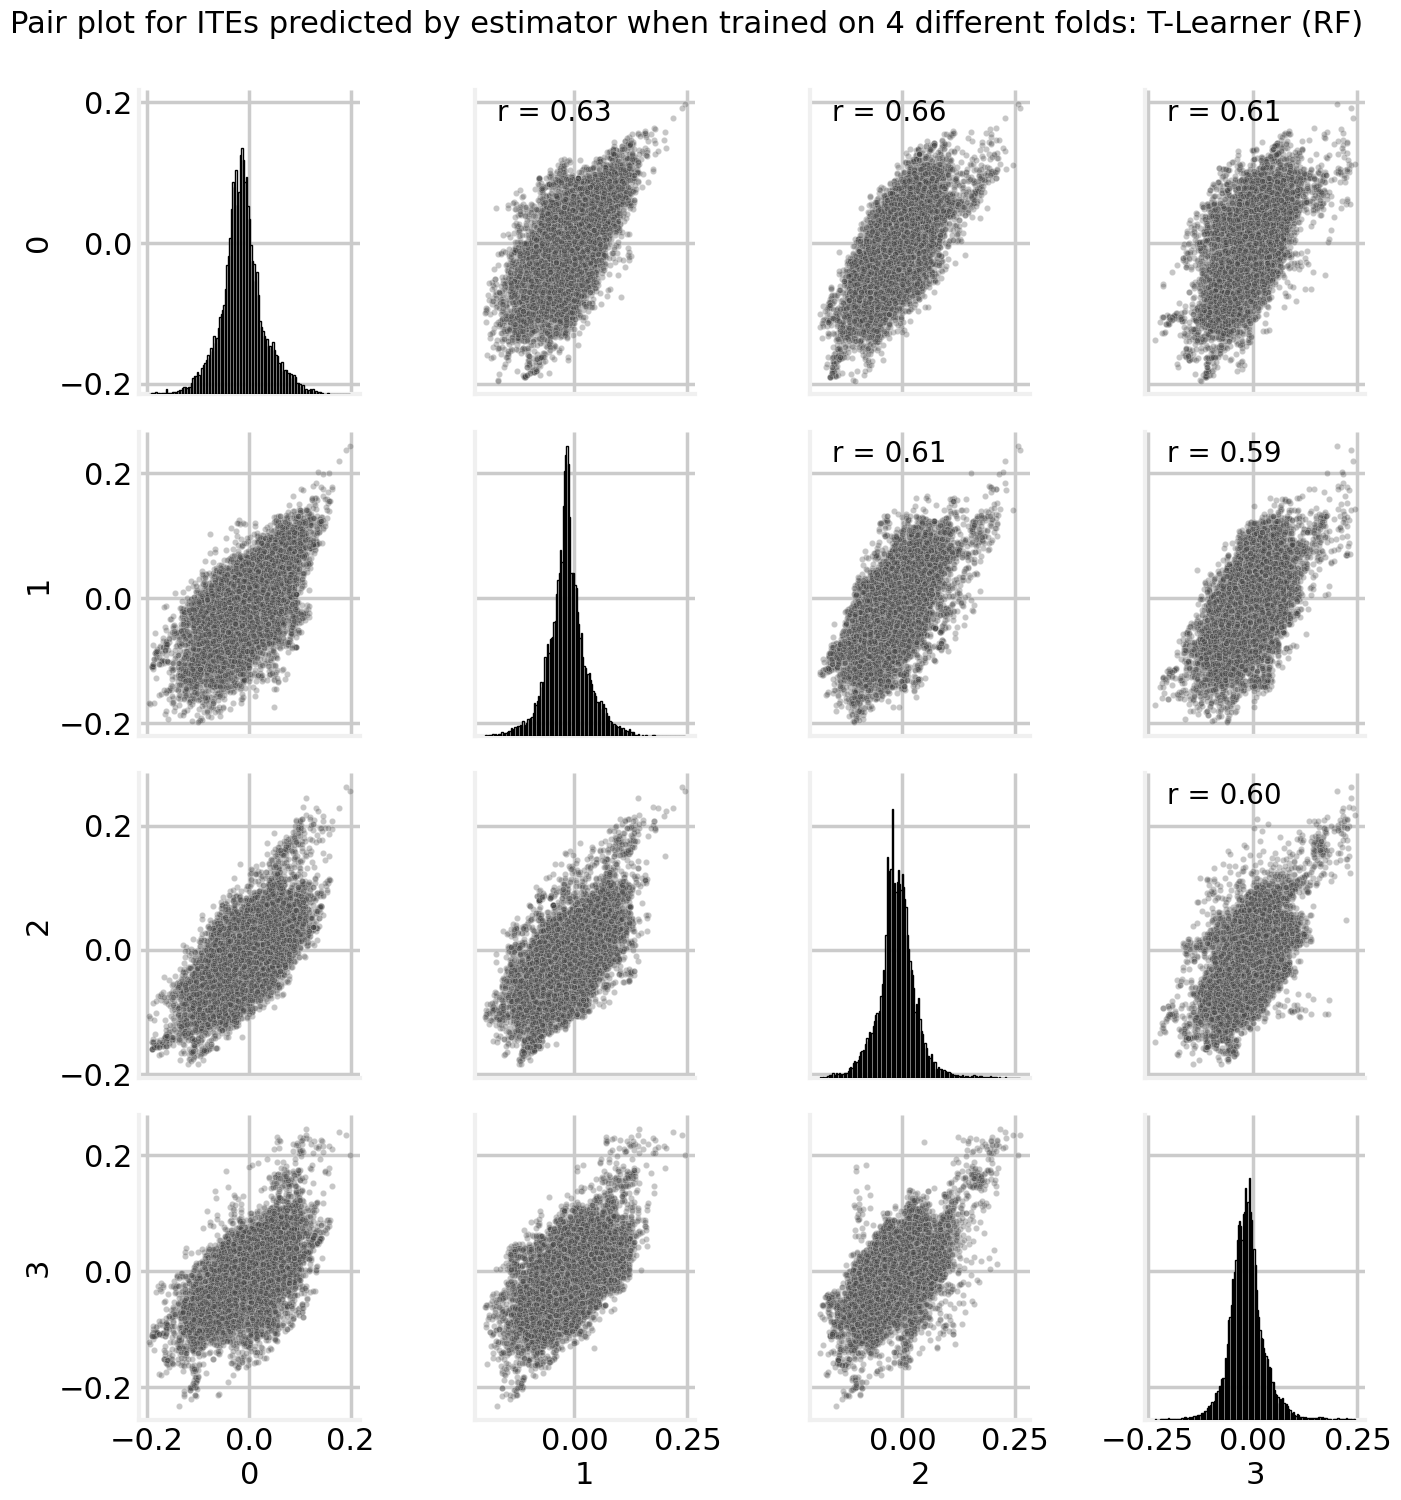

In [ ]:
make_model_CATE_pairplot(fitted_libraries["pert_none"]["t_rf"], "T-Learner (RF)")

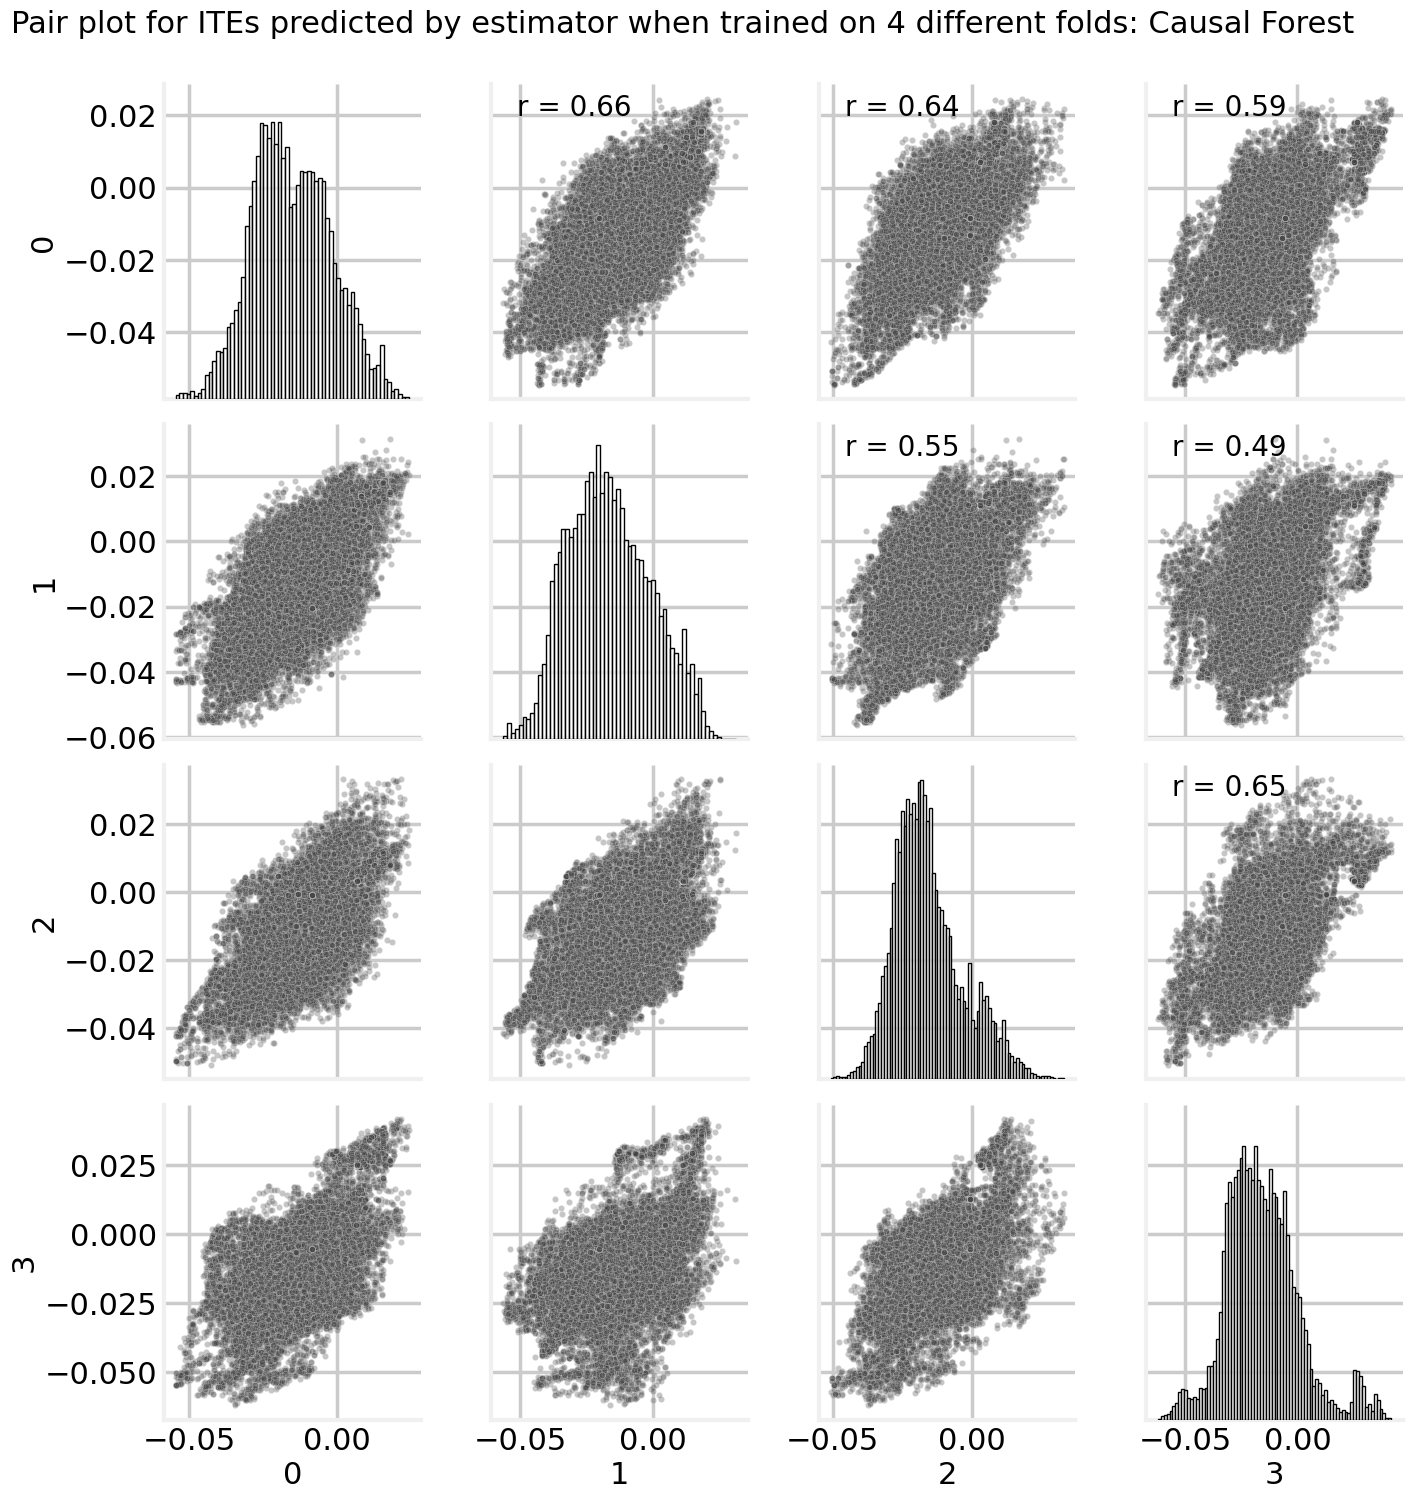

In [ ]:
make_model_CATE_pairplot(fitted_libraries["pert_none"]["causal_forest_1"], "Causal Forest")